# Sample Alignment

This notebook includes some test code for 29ID's sample alignment automation.  This code is incorporated into alignSample_lib.py (written for python/ipython)

In [1]:
%matplotlib notebook

# Set up simulated hardware.
from bluesky.plans import adaptive_scan
from bluesky.callbacks import LiveFit, LivePlot, LiveFitPlot, LiveTable

from ophyd.sim import SynAxis, SynGauss, SynSignal

import math

## Adaptive scans

First test adaptive scans

In [2]:
RE = RunEngine({})

In [3]:
theta_motor = SynAxis(name='theta_motor')
det_rot = SynGauss('det_rot', theta_motor, 'theta_motor', center=4.6, Imax=1,
               noise='uniform', sigma=.1, noise_multiplier=0.005)

<IPython.core.display.Javascript object>


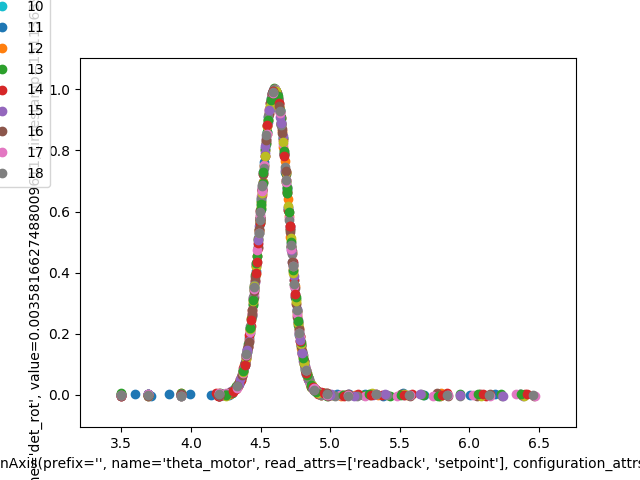

0

In [4]:
RE.subscribe(LivePlot(det_rot,theta_motor, marker = 'o', linestyle='none'))

In [5]:
RE(adaptive_scan([det_rot], 'det_rot', theta_motor, 
                 start = 3.5, 
                 stop = 6.5, 
                 min_step=0.01, #minimum step for theta_motor
                 max_step = 0.2, 
                 target_delta = 0.01, 
                 backstep = True), LiveTable([det_rot, theta_motor]))

+-----------+------------+------------+-------------+----------------------+
|   seq_num |       time |    det_rot | theta_motor | theta_motor_setpoint |
+-----------+------------+------------+-------------+----------------------+
|         1 | 09:19:38.5 |     -0.002 |       3.500 |                3.500 |
|         2 | 09:19:38.5 |      0.002 |       3.595 |                3.595 |
|         3 | 09:19:38.6 |     -0.002 |       3.711 |                3.711 |
|         4 | 09:19:38.6 |      0.004 |       3.844 |                3.844 |
|         5 | 09:19:38.6 |      0.004 |       3.990 |                3.990 |
|         6 | 09:19:38.6 |      0.001 |       4.147 |                4.147 |
|         7 | 09:19:38.6 |      0.016 |       4.313 |                4.313 |
|         8 | 09:19:38.6 |      0.003 |       4.256 |                4.256 |
|         9 | 09:19:38.6 |      0.093 |       4.383 |                4.383 |
|        10 | 09:19:38.7 |      0.001 |       4.270 |                4.270 |

('b7c77a58-61b7-4b11-9843-3ea7b4355f1a',)

## Fit to simulated/noisy gaussian

```theta_motor``` and ```det_rot```

In [47]:
import lmfit

def gaussian(x, A, sigma, x0):
    return A*np.exp(-(x - x0)**2/(2 * sigma**2))

rot_model = lmfit.Model(gaussian)
init_guess = {'A': 1,
              'sigma': lmfit.Parameter('sigma', .2, min=0),
              'x0': 5}

In [48]:
# LiveFit example
rot_lf = LiveFit(rot_model, 'det_rot', {'x': 'theta_motor'}, init_guess, update_every=5)

<IPython.core.display.Javascript object>


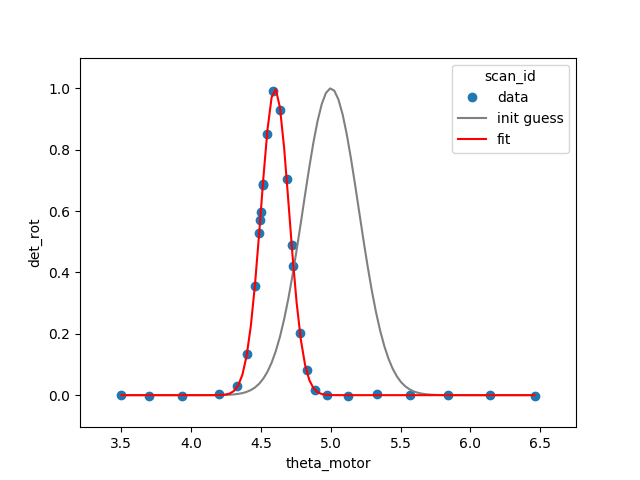

Maximum at theta =  4.600
Number of measurements:  28


In [79]:
# show the data on the same axes

fig, bx = plt.subplots()  # explitly create figure, axes to use below
rot_lfp = LiveFitPlot(rot_lf, ax=bx, color='r', label='fit')
rot_lp = LivePlot('det_rot','theta_motor', ax=bx, marker='o', linestyle='none', label='data')

RE(adaptive_scan([det_rot], 'det_rot', theta_motor, 
                  start = 3.5,
                  stop = 6.5, 
                  min_step = 0.01, #minimum step for theta_motor
                  max_step = 0.4, 
                  target_delta = 0.25,
                  backstep = True), [rot_lp, rot_lfp])

print('Maximum at theta = ',"{0:.3f}".format(rot_lf.result.params['x0'].value))
print('Number of measurements: ',len(rot_lp.x_data))

In [9]:
rot_lf.result.params

Parameters([('A',
             <Parameter 'A', value=0.99892020552526517 +/- 0.000758, bounds=[-inf:inf]>),
            ('sigma',
             <Parameter 'sigma', value=0.10008960477423545 +/- 9.12e-05, bounds=[0:inf]>),
            ('x0',
             <Parameter 'x0', value=4.6000354294341319 +/- 9.08e-05, bounds=[-inf:inf]>)])

In [10]:
rot_lf.result.params['A'].value, rot_lf.result.params['sigma'].value, rot_lf.result.params['x0'].value

(0.99892020552526517, 0.10008960477423545, 4.6000354294341319)

Peak value at x0

In [11]:
rot_lf.result.params['x0'].value

4.6000354294341319

## Simulated translation alignment

```x_motor``` and ```det_trans```

In [12]:
RE2 = RunEngine({})

Create a SynErf device (similar to SynGauss)

In [13]:
class SynErf(SynSignal):
    """
    Evaluate a point on a Gaussian based on the value of a motor.

    Parameters
    ----------
    name : string
    motor : Device
    motor_field : string
    center : number
        center of peak
    Imax : number
        max intensity of peak
    sigma : number, optional
        Default is 1.
    noise : {'poisson', 'uniform', None}
        Add noise to the gaussian peak.
    noise_multiplier : float
        Only relevant for 'uniform' noise. Multiply the random amount of
        noise by 'noise_multiplier'

    Example
    -------
    motor = SynAxis(name='motor')
    det = SynGauss('det', motor, 'motor', center=0, Imax=1, sigma=1)
    """
    import math
    
    def __init__(self, name, motor, motor_field, Imax, wid, x0,
                 noise=None, noise_multiplier=1, **kwargs):
        if noise not in ('poisson', 'uniform', None):
            raise ValueError("noise must be one of 'poisson', 'uniform', None")
        self._motor = motor

        def func():
            m = motor.read()[motor_field]['value']
            v = Imax * 0.5 * (1-math.erf(wid*(m-x0)))
#            v = Imax * np.exp(-(m - center) ** 2 / (2 * sigma ** 2))
            if noise == 'poisson':
                v = int(np.random.poisson(np.round(v), 1))
            elif noise == 'uniform':
                v += np.random.uniform(-1, 1) * noise_multiplier
            return v

        super().__init__(func=func, name=name, **kwargs)

In [14]:
x_motor = SynAxis(name='x_motor')
det_tran = SynErf('det_tran', x_motor, 'x_motor', Imax=0.024, wid=5.0, x0 = 0.2,
               noise='uniform', noise_multiplier=0.0005)
#det_tran = SynErf('det_tran', x_motor, 'x_motor', center=0, Imax=0.024, wid=10.0,
#               noise=None)

<IPython.core.display.Javascript object>


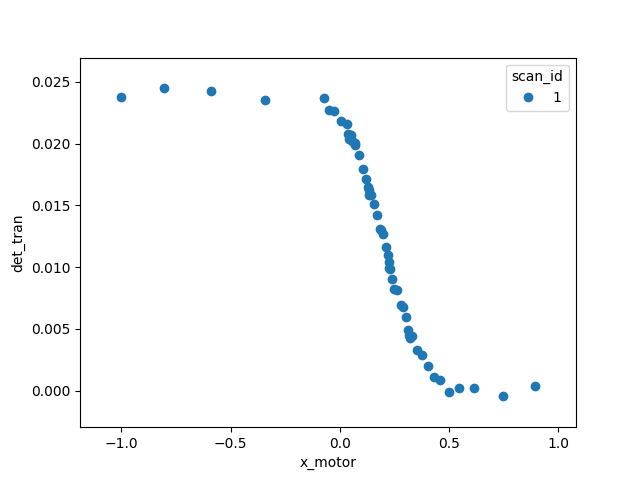

0

In [15]:
RE2.subscribe(LivePlot('det_tran','x_motor', marker='o', linestyle='none'))

In [16]:
RE2(adaptive_scan([det_tran], 'det_tran', x_motor, 
                  start = -1.0,
                  stop = 1.0, 
                  min_step=0.005, 
                  max_step = 0.4, 
                  target_delta = 0.001,
                  backstep = True), LiveTable([det_tran, x_motor]))

+-----------+------------+------------+------------+------------------+
|   seq_num |       time |   det_tran |    x_motor | x_motor_setpoint |
+-----------+------------+------------+------------+------------------+
|         1 | 09:21:20.5 |      0.024 |     -1.000 |           -1.000 |
|         2 | 09:21:20.5 |      0.024 |     -0.802 |           -0.802 |
|         3 | 09:21:20.5 |      0.024 |     -0.590 |           -0.590 |
|         4 | 09:21:20.5 |      0.024 |     -0.341 |           -0.341 |
|         5 | 09:21:20.6 |      0.024 |     -0.071 |           -0.071 |
|         6 | 09:21:20.6 |      0.010 |      0.225 |            0.225 |
|         7 | 09:21:20.6 |      0.023 |     -0.049 |           -0.049 |
|         8 | 09:21:20.6 |      0.023 |     -0.026 |           -0.026 |
|         9 | 09:21:20.6 |      0.021 |      0.037 |            0.037 |
|        10 | 09:21:20.6 |      0.022 |      0.008 |            0.008 |
|        11 | 09:21:20.6 |      0.020 |      0.043 |            

('a10a62cc-a40f-417b-88e9-985d3e7764fa',)

## Simulated Translation with Fitting

Set up error function (unlike gaussian, it's not part of LiveFit) to be fit to data

In [64]:
import numpy as np
import scipy
import lmfit

def erfx(x, low, high, wid, x0):
    return (high - low) * 0.5 * (1-scipy.special.erf((x-x0)*wid)) + low

trans_model = lmfit.Model(erfx)
init_guess = {'low': 0,
              'high': 0.03,
              'wid': lmfit.Parameter('wid', 10, min=0),
              'x0': -0.1}

Starting new RunEngine instance

In [65]:
RE3 = RunEngine({})

In [66]:
# LiveFit example
trans_lf = LiveFit(trans_model, 'det_tran', {'x': 'x_motor'}, init_guess, update_every=5)

Reusing ```det_tran``` and ```x_motor``` from previous section

<IPython.core.display.Javascript object>


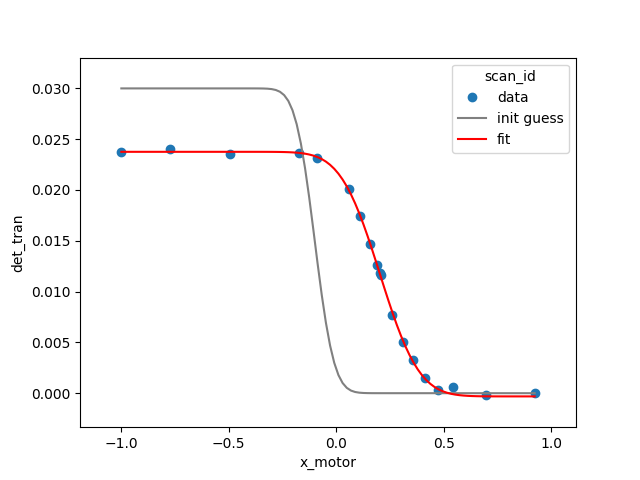

Half-maximum at x0: x0 =  0.20091
Number of measurements:  19


In [78]:
# show the data on the same axes

fig, ax = plt.subplots()  # explitly create figure, axes to use below
trans_lfp = LiveFitPlot(trans_lf, ax=ax, color='r', label = 'fit')
trans_lp = LivePlot('det_tran','x_motor', ax=ax, marker='o', linestyle='none', label = 'data')

RE3(adaptive_scan([det_tran], 'det_tran', x_motor, 
                  start = -1.0,
                  stop = 1.0, 
                  min_step = 0.05, #minimum step for theta_motor 
                  max_step = 0.5, 
                  target_delta = 0.0025,
                  backstep = True), [trans_lp, trans_lfp])

print('Half-maximum at x0: x0 = ',"{0:.5f}".format(trans_lf.result.params['x0'].value))
print('Number of measurements: ',len(trans_lp.x_data))

Now to get the paraemeters from the fit

In [29]:
trans_lf.result.params['low'].value, trans_lf.result.params['high'].value, trans_lf.result.params['wid'].value, trans_lf.result.params['x0'].value

(-7.3950012646567884e-05,
 0.023973585504710619,
 5.0951338926263938,
 0.20087731712062978)

In [22]:
half_max = 0.5*(trans_lf.result.params['high'].value - trans_lf.result.params['low'].value)
print(half_max)

0.0121395571602


By construction ```x0``` is location of half-max

In [26]:
trans_lf.result.params['x0'].value

0.20202162908976209